In [78]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

In [79]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/morpho/'
ground_truth_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv', sep=',')
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/'

In [80]:
model_dict = {'SimCLR UKB': '2023-06-15/14-36-49/',
              'morpho positional': 'morpho/morpho_positional/',
              'morpho shape': 'morpho/morpho_shape/',
              'morpho all': 'morpho/morpho_all/'}

In [22]:
# load probabilities of embeddings pipeline
# then find best threshold
label=28
classif_dict = {}

for model, model_dir in model_dict.items():
    print(model)
    print('\n')
    predictions = pd.read_csv(dir+model_dir+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/cross_val_predicted_probas.csv')
    predictions = predictions['average_model']
    true_labels = ground_truth_labels[f'Preterm_{label}']

    # first find good threshold
    # optimize balanced accuracy
    thresholds = np.linspace(0,1,1000)
    # the labels could be either in ascending or descending order
    accuracies = [max(balanced_accuracy_score(true_labels, predictions > threshold),
                    balanced_accuracy_score(true_labels, predictions < threshold))
                for threshold in thresholds]

    preds_0 = predictions < thresholds[np.argmax(accuracies)]
    preds_1 = predictions > thresholds[np.argmax(accuracies)]
    if balanced_accuracy_score(true_labels, preds_0) > balanced_accuracy_score(true_labels, preds_1):
        preds = preds_0
    else:
        preds = preds_1

    print(f'best balanced accuracy: {max(accuracies)} \nbest threshold: {thresholds[np.argmax(accuracies)]}]')

    conf_matrix = confusion_matrix(true_labels, preds)
    print(f'Confusion Matrix:\nTN = {conf_matrix[0, 0]}\nFP = {conf_matrix[0, 1]}\nFN = {conf_matrix[1, 0]}\nTP = {conf_matrix[1, 1]}')

    # make groups of subjects for gradient averaging
    TN_subjects = np.where((np.array(true_labels)==0) & (preds==0))[0]
    FP_subjects = np.where((np.array(true_labels)==0) & (preds==1))[0]
    FN_subjects = np.where((np.array(true_labels)==1) & (preds==0))[0]
    TP_subjects = np.where((np.array(true_labels)==1) & (preds==1))[0]

    classif_dict[model]={'TN': TN_subjects,
                        'FP': FP_subjects,
                        'FN': FN_subjects,
                        'TP': TP_subjects}
    print('\n')

UKB


best balanced accuracy: 0.805114899925871 
best threshold: 0.06106106106106106]
Confusion Matrix:
TN = 254
FP = 101
FN = 2
TP = 17


morpho positional


best balanced accuracy: 0.5616753150481838 
best threshold: 0.029029029029029027]
Confusion Matrix:
TN = 268
FP = 87
FN = 12
TP = 7


morpho shape


best balanced accuracy: 0.8323202372127502 
best threshold: 0.06106106106106106]
Confusion Matrix:
TN = 292
FP = 63
FN = 3
TP = 16


morpho all


best balanced accuracy: 0.8275759822090437 
best threshold: 0.12312312312312312]
Confusion Matrix:
TN = 326
FP = 29
FN = 5
TP = 14




In [23]:
def IOU_labels(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    set_inter = set1.intersection(set2)
    set_union = set1.union(set2)
    return(str(len(set_inter)) + ' / ' + str(len(set_union)))
           
def IOU(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    set_inter = set1.intersection(set2)
    set_union = set1.union(set2)
    if len(set_union) > 0:
        iou = len(set_inter) / len(set_union)
    else:
        iou = 0 
    return(iou)

def Intersect(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    set_inter = set1.intersection(set2)
    if len(set1) > 0:
        intersect = len(set_inter) / len(set1)
    else:
        intersect = 0 
    return(intersect)

def Intersect_labels(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    set_inter = set1.intersection(set2)
    return(str(len(set_inter)))

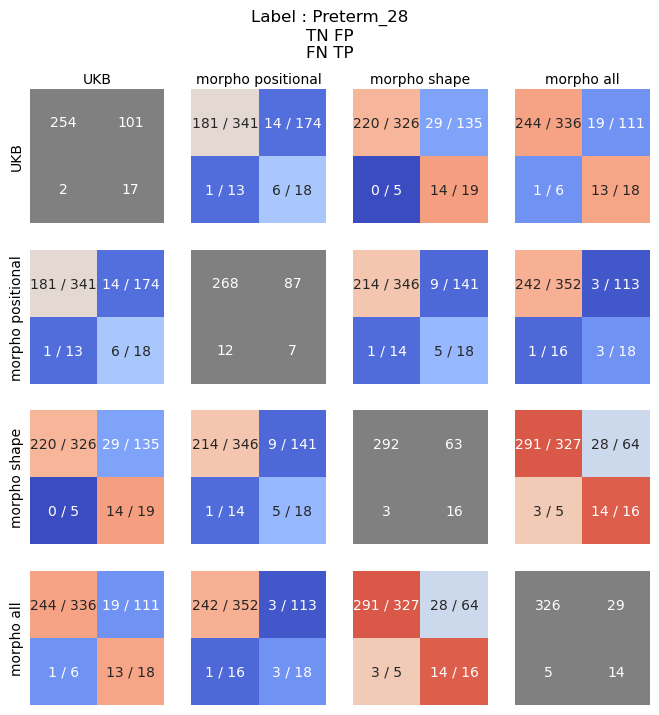

In [24]:
# plot confusion matrix IOU for each couple of models
plt.close()
cmap = mpl.cm.get_cmap("coolwarm").copy()
gray_cmap = mpl.colors.ListedColormap([[0.5,0.5,0.5,1]], name='gray_cmap')
norm = plt.Normalize(0, 1)

n = len(classif_dict.keys())
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(2*n, 2*n))
for i, model1 in enumerate(classif_dict.keys()):
    for j, model2 in enumerate(classif_dict.keys()):
        ax = axs[i, j]
        if i==j:
            matrix = np.array([[len(classif_dict[model1]['TN']), len(classif_dict[model1]['FP'])],
                               [len(classif_dict[model1]['FN']), len(classif_dict[model1]['TP'])]])
            sns.heatmap(matrix, ax=ax, annot=True, cbar=False, cmap=gray_cmap, fmt='g')
        else:
            matrix = np.array([[IOU(classif_dict[model1]['TN'], classif_dict[model2]['TN']), IOU(classif_dict[model1]['FP'], classif_dict[model2]['FP'])],
                                [IOU(classif_dict[model1]['FN'], classif_dict[model2]['FN']), IOU(classif_dict[model1]['TP'], classif_dict[model2]['TP'])]])
            labels = np.array([[IOU_labels(classif_dict[model1]['TN'], classif_dict[model2]['TN']), IOU_labels(classif_dict[model1]['FP'], classif_dict[model2]['FP'])],
                                [IOU_labels(classif_dict[model1]['FN'], classif_dict[model2]['FN']), IOU_labels(classif_dict[model1]['TP'], classif_dict[model2]['TP'])]])
            
            sns.heatmap(matrix, ax=ax, annot=labels, cbar=False, cmap=cmap, norm=norm, fmt='')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

for i in range(n):
    axs[i,0].set_ylabel(list(classif_dict.keys())[i])
    axs[0,i].set_xlabel(list(classif_dict.keys())[i])
    axs[0,i].xaxis.set_label_position('top')

plt.suptitle(f'Label : Preterm_{label}\nTN FP\nFN TP')
plt.savefig(save_dir+f'IOU_comparison_models_preterm_{label}.png', facecolor='white')
plt.show()

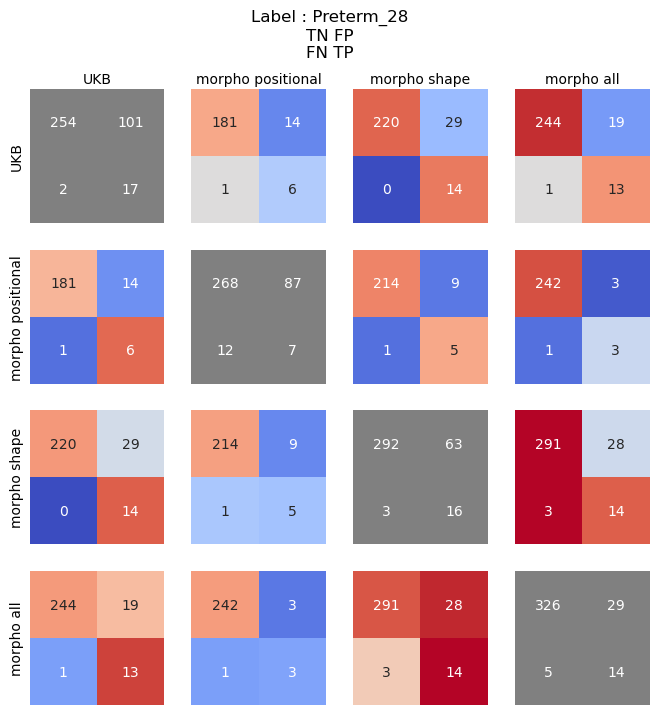

In [25]:
# plot confusion matrix IOU for each couple of models
plt.close()
cmap = mpl.cm.get_cmap("coolwarm").copy()
gray_cmap = mpl.colors.ListedColormap([[0.5,0.5,0.5,1]], name='gray_cmap')
norm = plt.Normalize(0, 1)

n = len(classif_dict.keys())
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(2*n, 2*n))
for i, model1 in enumerate(classif_dict.keys()):
    for j, model2 in enumerate(classif_dict.keys()):
        ax = axs[i, j]
        if i==j:
            matrix = np.array([[len(classif_dict[model1]['TN']), len(classif_dict[model1]['FP'])],
                               [len(classif_dict[model1]['FN']), len(classif_dict[model1]['TP'])]])
            sns.heatmap(matrix, ax=ax, annot=True, cbar=False, cmap=gray_cmap, fmt='g')
        else:
            matrix = np.array([[Intersect(classif_dict[model1]['TN'], classif_dict[model2]['TN']), Intersect(classif_dict[model1]['FP'], classif_dict[model2]['FP'])],
                                [Intersect(classif_dict[model1]['FN'], classif_dict[model2]['FN']), Intersect(classif_dict[model1]['TP'], classif_dict[model2]['TP'])]])
            labels = np.array([[Intersect_labels(classif_dict[model1]['TN'], classif_dict[model2]['TN']), Intersect_labels(classif_dict[model1]['FP'], classif_dict[model2]['FP'])],
                                [Intersect_labels(classif_dict[model1]['FN'], classif_dict[model2]['FN']), Intersect_labels(classif_dict[model1]['TP'], classif_dict[model2]['TP'])]])
            
            sns.heatmap(matrix, ax=ax, annot=labels, cbar=False, cmap=cmap, norm=norm, fmt='')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

for i in range(n):
    axs[i,0].set_ylabel(list(classif_dict.keys())[i])
    axs[0,i].set_xlabel(list(classif_dict.keys())[i])
    axs[0,i].xaxis.set_label_position('top')

plt.suptitle(f'Label : Preterm_{label}\nTN FP\nFN TP')
plt.show()

In [21]:
# NB: shape and all have similar performances but don't make the same mistakes!
# Still, the Intersect values depend on an arbitrary threshold!
# NO PERFECT METRIC !!

In [94]:
classif_dict['morpho all']['FN']

array([ 34,  81, 106, 244, 283, 306, 310, 316, 334, 339, 341, 345, 351,
       353, 356, 359, 360])

In [95]:
classif_dict['morpho shape']['FN']

array([ 34,  35,  80, 137, 244, 248, 262, 283, 288, 298, 306, 316, 334,
       345, 353, 356, 360])

# Inspire from AUC regression

In [26]:
def regression_roc_auc_score(y_true, y_pred, num_rounds=10000):
    """
    Computes Regression-ROC-AUC-score.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    y_pred: array-like of shape (n_samples,). Target scores.
    num_rounds: int or string.
                If integer, number of random pairs of observations.
                If string, 'exact', all possible pairs will be evaluated.

    Returns:
    -------
    rroc: float. Regression-ROC-AUC-score.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0

    for i, j in _yield_pairs(y_true, num_rounds):
        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
            num_same_sign += 1
        elif diff_score == 0:
            num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
    """
    Returns pairs of valid indices.

    Indices must belong to observations having different values.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    num_rounds: int or string.
            If integer, number of random pairs of observations to return.
            If string, 'exact', all possible pairs will be returned.

    Yields:
    -------
    i, j: tuple of int of shape (2,). Indices referred to a pair of samples.

    """
    import numpy as np

    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where(
                    (y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j

In [104]:
label = 28

true_labels = ground_truth_labels[f'Preterm_{label}']
pred_dict = {'positive': {},
             'negative': {}}
for model, model_dir in model_dict.items():
    
    predictions = pd.read_csv(dir+model_dir+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/cross_val_predicted_probas.csv')
    predictions = predictions['average_model'].to_numpy()

    pred_dict['positive'][model] = predictions[np.where(true_labels)]
    pred_dict['negative'][model] = predictions[np.where(1-true_labels)]

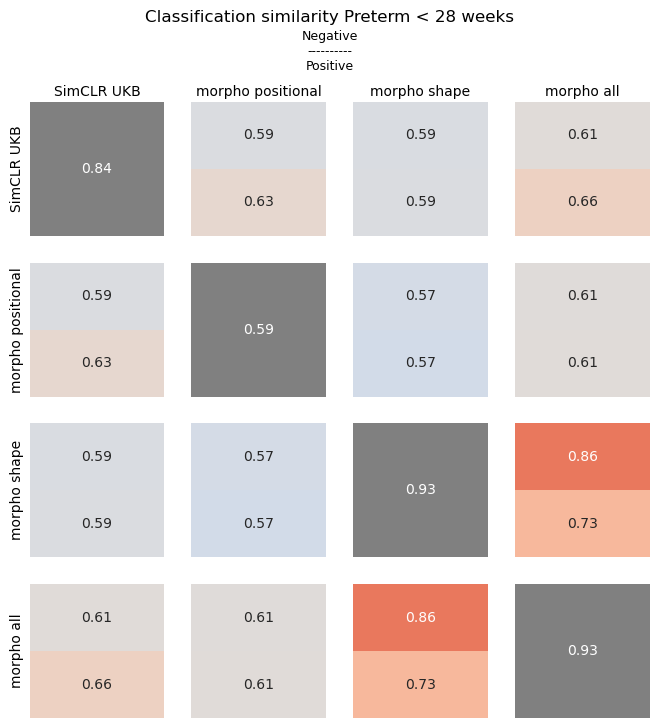

In [105]:
plt.close()

cmap = mpl.cm.get_cmap("coolwarm").copy()
gray_cmap = mpl.colors.ListedColormap([[0.5,0.5,0.5,1]], name='gray_cmap')
norm = plt.Normalize(0.2, 1)
niter=10000

n = len(pred_dict['positive'].keys())
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(2*n, 2*n))
for i, model1 in enumerate(pred_dict['positive'].keys()):
    for j, model2 in enumerate(pred_dict['negative'].keys()):
        if i==j:
            ax = axs[i,j]
            with open(dir+model_dict[model1]+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/values.json') as f:
                auc_classif = json.load(f)
                auc_classif = auc_classif['cross_val_auc'][0]
            mat = np.array([[auc_classif]])
            sns.heatmap(mat, ax=ax, annot=True, cbar=False, cmap=gray_cmap)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
        elif j < i:
            d1, d2 = pred_dict['positive'][model1], pred_dict['positive'][model2]
            sim_pos = max(regression_roc_auc_score(d1, d2, niter), regression_roc_auc_score(d1, 1-d2, niter)) #d1 could be pushed to 0 and d2 to 1 ?
            d1, d2 = pred_dict['negative'][model1], pred_dict['negative'][model2]
            sim_neg = max(regression_roc_auc_score(d1, d2, niter), regression_roc_auc_score(d1, 1-d2, niter))
            sim_mat = np.array([[sim_neg], [sim_pos]])

            ax = axs[i,j]
            sns.heatmap(sim_mat, ax=ax, annot=True, cbar=False, cmap=cmap, norm=norm)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax = axs[j,i]
            sns.heatmap(sim_mat, ax=ax, annot=True, cbar=False, cmap=cmap, norm=norm)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

for i in range(n):
    axs[i,0].set_ylabel(list(pred_dict['positive'].keys())[i])
    axs[0,i].set_xlabel(list(pred_dict['negative'].keys())[i])
    axs[0,i].xaxis.set_label_position('top')

#plt.suptitle(f'Label : Preterm_{label}\nNegative\n----------\nPositive', fmtsize=10)
plt.text(x=0.5, y=0.98, s=f"Classification similarity Preterm < {label} weeks", fontsize=12, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.92, s= "Negative\n----------\nPositive", fontsize=9, ha="center", transform=fig.transFigure)
plt.savefig(save_dir+f'classification_similarities_Preterm_{label}.png')
plt.show()
